# Problem 2. CLs plots

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zfit
from zfit import z
from scipy.stats import chi2
from tqdm.autonotebook import tqdm
tqdm.pandas()
import multiprocess as mp
import warnings
warnings.filterwarnings("ignore")

os.environ['ZFIT_DISABLE_TF_WARNINGS'] = '1'

# data = np.load("../Data/toy_dataset.csv.npy")
data = np.load("../Data/toy_dataset_smaller_peak.npy")

Making a CLs plot. We will now make a typical CLs plot like that shown in Fig. 2. Remember that in CLs we talk about exclusion, so that your ”null” hypothesis that you would like to exclude is your signal and background hypothesis. IMPORTANT - again as we aren’t doing that many toys, for some of the points the test-statistic under the signal and background (i.e. null) hypothesis may not cover the data, in which case you may use Wilkes theoerm to extract a p-value. When I tested toys on both the large and small peak datasets, the test statistic under the background (i.e. alternative) hypothesis generally covered the data so this should be fine.

## a)

Use again the profile likelihood test statistic, but this time you have a test statistic for a given hypothesied particle mass, mSM . Generate the test-statistic in intervals of 5 MeV from mSM = 110 to mSM = 150 under the signal and background hypothesis. You should run 100-200 pseudodatasets per point. Provide all the test statistics on one plot.

---

### Solution



In [ ]:
obs = zfit.Space("x", limits=(np.min(data)-1, np.max(data)+1))
zfit_data = zfit.Data.from_numpy(obs=obs, array=data[:, 0])


n_real = len(data)

mass_hypotheses = np.arange(110, 155, 5)  # 110 to 150 GeV in 5 GeV steps

n_pseudo = 100

def perform_pseudo_experiment(mass, obs, n_real, zfit_data):
    # SB model
    mean = zfit.Parameter(f"mean_{mass}", mass)
    sigma = zfit.Parameter("sigma", 2.0, floating=False)  # Fixed detector resolution
    signal_model = zfit.pdf.Gauss(mu=mean, sigma=sigma, obs=obs)
    lambda_sb = zfit.Parameter(f"lambda_sb_{mass}", -0.01, -1.0, 1.0)
    exp_bkg_model_sb = zfit.pdf.Exponential(lam=lambda_sb, obs=obs)
    frac_signal = zfit.Parameter(f"frac_signal_{mass}", 0.5, 0.0, 1.0)
    sb_model = zfit.pdf.SumPDF([exp_bkg_model_sb, signal_model], fracs=frac_signal)


    pseudo_data = sb_model.sample(n=n_real).numpy()
    zfit_pseudo_data = zfit.Data.from_numpy(obs=obs, array=pseudo_data[:, 0])


    # Background-only model
    lambda_bkg = zfit.Parameter("lambda_bkg", -0.01, -1.0, 1.0)
    exp_bkg_model = zfit.pdf.Exponential(lam=lambda_bkg, obs=obs)


    ### Fit the models
    ## Background
    nll_bkg = zfit.loss.UnbinnedNLL(model=exp_bkg_model, data=zfit_pseudo_data)
    minimizer_bkg = zfit.minimize.Minuit()
    res_bkg = minimizer_bkg.minimize(nll_bkg)
    nll_bkg_min = nll_bkg.value().numpy()

    ## Signal+Background
    nll_sb = zfit.loss.UnbinnedNLL(model=sb_model, data=zfit_pseudo_data)
    minimizer_sb = zfit.minimize.Minuit()
    res_sb = minimizer_sb.minimize(nll_sb)
    nll_sb_min = nll_sb.value().numpy()

    t_stat = 2 * (nll_bkg_min - nll_sb_min)
    return t_stat


In [ ]:
import glob
PATH_2_SOL_DATASETS = "../sol_datasets/"
# Check if the datasets are already generated
if glob.glob(PATH_2_SOL_DATASETS + "2a.csv"):
    print("Loading datasets from disk")
    df_a = pd.read_csv(PATH_2_SOL_DATASETS + "2a.csv")

else:

    results = {"mass": [], "test_statistic": []}
    for mass in range(110, 151, 5):
        print(f"mass = {mass}")
        test_statistic = []
        for _ in tqdm(range(n_pseudo)):
            test_statistic += [perform_pseudo_experiment(mass, obs, n_real, zfit_data)]
        test_statistic = np.array(test_statistic)
        results["mass"] += [mass]*n_pseudo
        results["test_statistic"] += test_statistic.tolist()
    df_a = pd.DataFrame(results)
    df_a.to_csv(PATH_2_SOL_DATASETS + "2a.csv")

mass = 110


  0%|          | 0/100 [00:00<?, ?it/s]

mass = 115


  0%|          | 0/100 [00:00<?, ?it/s]

mass = 120


  0%|          | 0/100 [00:00<?, ?it/s]

mass = 125


  0%|          | 0/100 [00:00<?, ?it/s]

mass = 130


  0%|          | 0/100 [00:00<?, ?it/s]

mass = 135


  0%|          | 0/100 [00:00<?, ?it/s]

mass = 140


  0%|          | 0/100 [00:00<?, ?it/s]

mass = 145


  0%|          | 0/100 [00:00<?, ?it/s]

mass = 150


  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Distribution of the test statistic 2.a)')

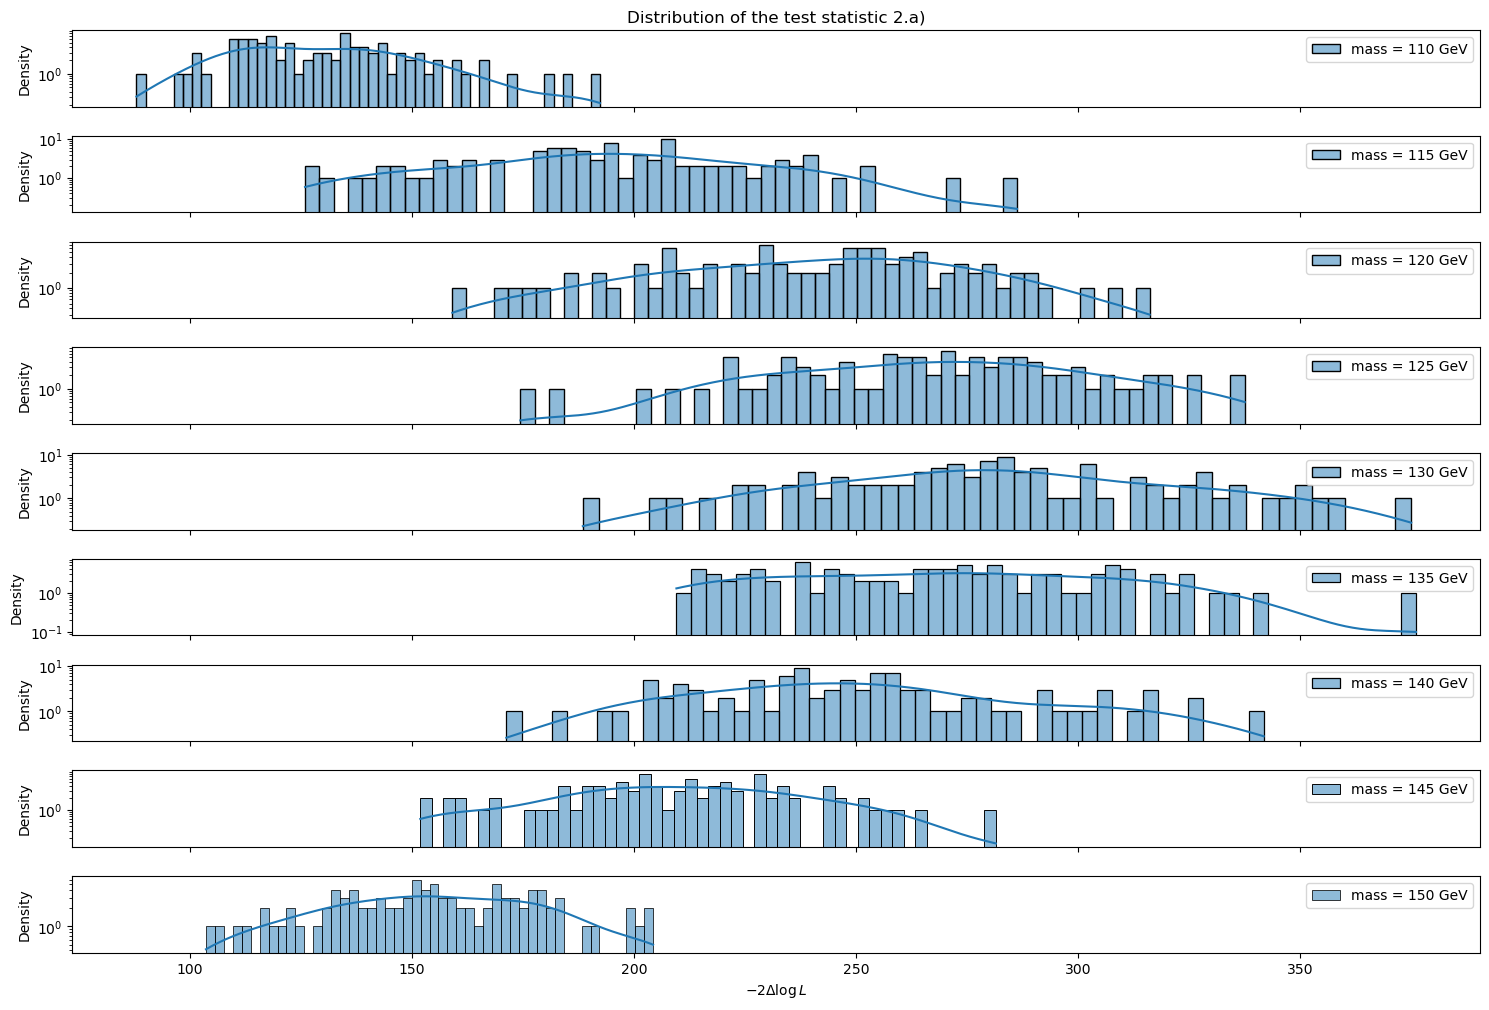

In [ ]:
df_b = pd.DataFrame(results)
import seaborn as sns
fig, ax = plt.subplots(len(mass_hypotheses), 1, figsize=(15, 10,), sharex=True)
for i, mass in enumerate(mass_hypotheses):
    sns.histplot(df_b.query(f"mass == {mass}")["test_statistic"], bins=50, ax=ax[i], label=f"mass = {mass} GeV", kde=True)
    ax[i].set_yscale("log")
    ax[i].set_xlabel(r"$-2 \Delta \log L$")
    ax[i].set_ylabel("Density")
    ax[i].legend()
fig.tight_layout()
# Set title
ax[0].set_title("Distribution of the test statistic 2.a)")

## b)

 Do the same again but for the background-only hypothesis. Will the test statistic generated under the background-only hypothesis change with different values of mSM ?

---
### Solution

In [76]:
def perform_pseudo_experiment_b(mass, obs, n_real, zfit_data):

    # SB model
    mean = zfit.Parameter(f"mean_{mass}", mass, floating=False)  # Fixed mass
    sigma = zfit.Parameter("sigma", 2.0, floating=False)  # Fixed detector resolution
    signal_model = zfit.pdf.Gauss(mu=mean, sigma=sigma, obs=obs)
    lambda_sb = zfit.Parameter(f"lambda_sb_{mass}", -0.01, -1.0, 1.0)
    exp_bkg_model_sb = zfit.pdf.Exponential(lam=lambda_sb, obs=obs)
    frac_signal = zfit.Parameter(f"frac_signal_{mass}", 0.5, 0.0, 1.0)
    sb_model = zfit.pdf.SumPDF([exp_bkg_model_sb, signal_model], fracs=frac_signal)

    # Background-only model
    lambda_bkg = zfit.Parameter("lambda_bkg", -0.01, -1.0, 1.0)
    exp_bkg_model = zfit.pdf.Exponential(lam=lambda_bkg, obs=obs)


    pseudo_data = exp_bkg_model.sample(n=n_real).numpy()
    zfit_pseudo_data = zfit.Data.from_numpy(obs=obs, array=pseudo_data[:, 0])


    ### Fit the models
    ## Background
    nll_bkg = zfit.loss.UnbinnedNLL(model=exp_bkg_model, data=zfit_pseudo_data)
    minimizer_bkg = zfit.minimize.Minuit()
    res_bkg = minimizer_bkg.minimize(nll_bkg)
    nll_bkg_min = nll_bkg.value().numpy()

    ## Signal+Background
    nll_sb = zfit.loss.UnbinnedNLL(model=sb_model, data=zfit_pseudo_data)
    minimizer_sb = zfit.minimize.Minuit()
    res_sb = minimizer_sb.minimize(nll_sb)
    nll_sb_min = nll_sb.value().numpy()

    t_stat = 2 * (nll_bkg_min - nll_sb_min)
    return t_stat


Text(0.5, 1.0, 'Distribution of the test statistic 2.b)')

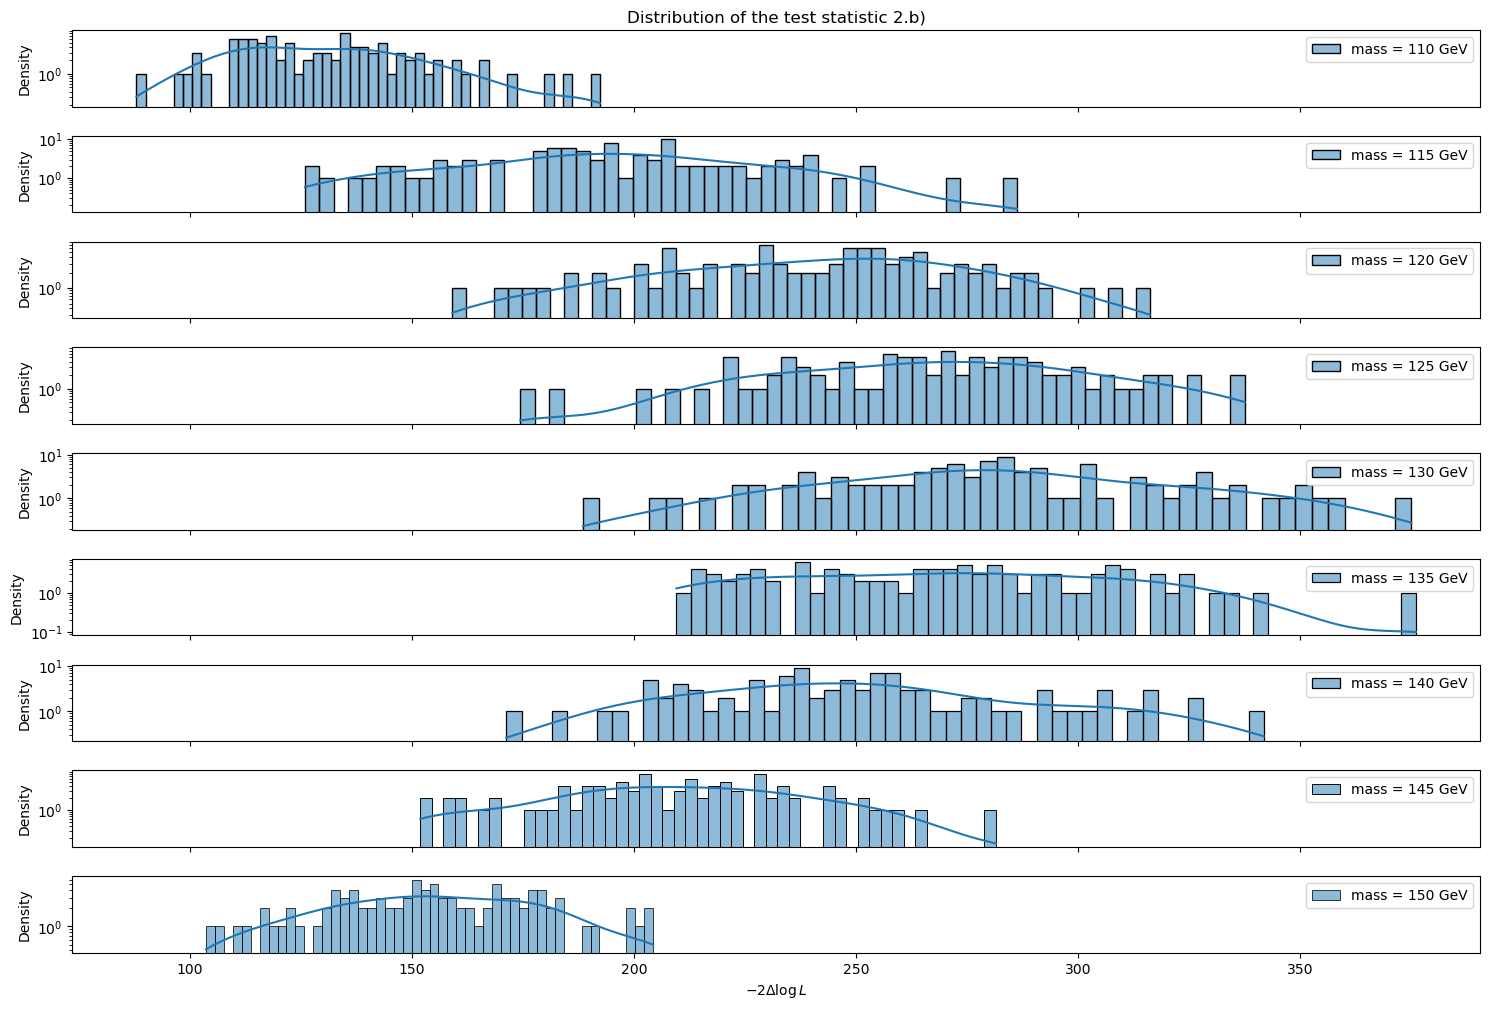

In [77]:
df_b = pd.DataFrame(results)
import seaborn as sns
fig, ax = plt.subplots(len(mass_hypotheses), 1, figsize=(15, 10,), sharex=True)
for i, mass in enumerate(mass_hypotheses):
    sns.histplot(df_b.query(f"mass == {mass}")["test_statistic"], bins=50, ax=ax[i], label=f"mass = {mass} GeV", kde=True)
    ax[i].set_yscale("log")
    ax[i].set_xlabel(r"$-2 \Delta \log L$")
    ax[i].set_ylabel("Density")
    ax[i].legend()
fig.tight_layout()
# Set title
ax[0].set_title("Distribution of the test statistic 2.b)")

## c)

Pick one of the mSM points, and calculate the power of the test-statistic for this point, assuming a confidence level of 0.05.

---

### Solution

In [78]:
def calculate_power(df_signal, df_background, mass_point, confidence_level=0.05):
    """
    Calculate the power of the test-statistic for a given mass point.

    Parameters:
    - df_signal: DataFrame containing test statistics under S+B hypothesis.
    - df_background: DataFrame containing test statistics under B-only hypothesis.
    - mass_point: The specific mass point (mSM) to evaluate.
    - confidence_level: The confidence level for the critical value (default is 0.05).

    Returns:
    - critical_value: The critical value at the specified confidence level.
    - power: The calculated power of the test.
    """
    # Extract test statistics for the specified mass point
    t_sb = df_signal[df_signal["mass"] == mass_point]["test_statistic"].values
    t_b = df_background[df_background["mass"] == mass_point]["test_statistic"].values

    # Check if there are enough pseudo-experiments
    if len(t_sb) < 20 or len(t_b) < 20:
        print("Warning: Limited number of pseudo-experiments. Consider increasing 'n_pseudo'.")

    # Calculate the critical value (percentile corresponding to 1 - CL)
    critical_percentile = 100 * (1 - confidence_level)
    critical_value = np.percentile(t_sb, critical_percentile)

    # Calculate the power: fraction of background test stats exceeding the critical value
    power = np.sum(t_b > critical_value) / len(t_b)

    return critical_value, power


In [79]:
# Choose the mass point
mass_point = 130  # in GeV

# Calculate the critical value and power
critical_value, power = calculate_power(df_a, df_b, mass_point, confidence_level=0.05)

# Display the results
print(f"Mass point: {mass_point} GeV")
print(f"Critical value (95th percentile of t_S+B): {critical_value:.2f}")
print(f"Power of the test (P(t_B > c)): {power:.2f}")


Mass point: 130 GeV
Critical value (95th percentile of t_S+B): 345.63
Power of the test (P(t_B > c)): 0.05


In [ ]:
for mass in mass_hypotheses:
    t_bkg = df_b[df_b["mass"] == mass]["test_statistic"].values
    critical_value = np.percentile(df_a[df_a["mass"] == mass]["test_statistic"], 95)
    clb = np.sum(t_bkg >= critical_value) / len(t_bkg)
    print(f"Mass: {mass} GeV | CLb: {clb}")


Mass: 110 GeV | CLb: 0.05
Mass: 115 GeV | CLb: 0.05
Mass: 120 GeV | CLb: 0.05
Mass: 125 GeV | CLb: 0.05
Mass: 130 GeV | CLb: 0.05
Mass: 135 GeV | CLb: 0.05
Mass: 140 GeV | CLb: 0.05
Mass: 145 GeV | CLb: 0.05
Mass: 150 GeV | CLb: 0.05


## d)

Use this ensemble of test statistics to make the CLs plot, with one entry for each of the points of mSM you have calculated the test statistics for.

---

### Solution



In [ ]:
def compute_cls_corrected(df_sb, df_bkg, mass_point, confidence_level=0.05):
    """
    Correctly compute CLs for a given mass point based on the B-only hypothesis.

    Parameters:
    - df_sb: DataFrame containing test statistics under S+B hypothesis.
    - df_bkg: DataFrame containing test statistics under B-only hypothesis.
    - mass_point: The specific mass point (mSM) to evaluate.
    - confidence_level: The confidence level for the critical value (default is 0.05).

    Returns:
    - cls: The CLs value for the mass point.
    """
    # Extract test statistics for the specified mass point
    t_sb = df_sb[df_sb["mass"] == mass_point]["test_statistic"].values
    t_bkg = df_bkg[df_bkg["mass"] == mass_point]["test_statistic"].values

    # Check if there are enough pseudo-experiments
    if len(t_sb) < 20 or len(t_bkg) < 20:
        print(f"Warning: Limited number of pseudo-experiments for mass point {mass_point} GeV.")

    # Calculate the critical value from the B-only distribution
    critical_percentile = 100 * (1 - confidence_level)
    critical_value = np.percentile(t_bkg, critical_percentile)

    # Calculate CLsb: Fraction of S+B test stats >= critical value
    clsb = np.sum(t_sb >= critical_value) / len(t_sb)

    # CLb is by definition equal to the confidence_level (0.05)
    clb = confidence_level

    # Compute CLs
    cls = clsb / clb

    return cls

# Define mass points
mass_hypotheses = sorted(df_a['mass'].unique())

# Initialize a list to store CLs results
cls_results = {"mass": [], "CLs": []}

for mass in mass_hypotheses:
    cls = compute_cls_corrected(df_a, df_b, mass, confidence_level=0.05)
    cls_results["mass"].append(mass)
    cls_results["CLs"].append(cls)
    print(f"Mass: {mass} GeV | CLs: {cls:.4f}")




Mass: 110 GeV | CLs: 1.0000
Mass: 115 GeV | CLs: 1.0000
Mass: 120 GeV | CLs: 1.0000
Mass: 125 GeV | CLs: 1.0000
Mass: 130 GeV | CLs: 1.0000
Mass: 135 GeV | CLs: 1.0000
Mass: 140 GeV | CLs: 1.0000
Mass: 145 GeV | CLs: 1.0000
Mass: 150 GeV | CLs: 1.0000


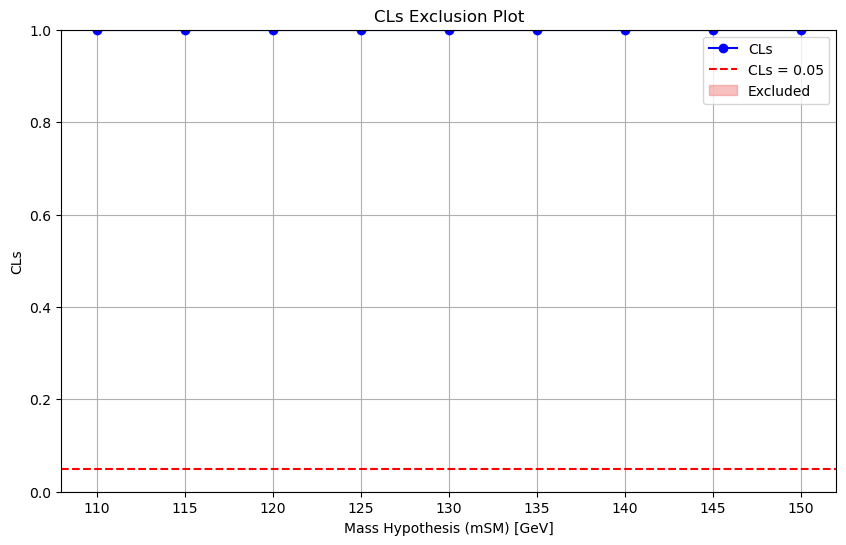

In [84]:
import matplotlib.pyplot as plt

# Create DataFrame for CLs
df_cls = pd.DataFrame(cls_results)

plt.figure(figsize=(10, 6))
plt.plot(df_cls['mass'], df_cls['CLs'], marker='o', linestyle='-', color='blue', label='CLs')

# Add a horizontal line at CLs = 0.05 for the exclusion threshold
plt.axhline(y=0.05, color='red', linestyle='--', label='CLs = 0.05')

# Highlight excluded regions where CLs < 0.05
plt.fill_between(df_cls['mass'], df_cls['CLs'], 0.05, where=(df_cls['CLs'] < 0.05), color='lightcoral', alpha=0.5, label='Excluded')

plt.title('CLs Exclusion Plot')
plt.xlabel('Mass Hypothesis (mSM) [GeV]')
plt.ylabel('CLs')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.xticks(mass_hypotheses)
plt.show()


(e) Comment on the plot - where can you exclude the signal and background hypothesis with 95% CL, where can’t you? Is this plot as your expect. How would you improve this plot?